# SHAP
This example interactively demonstrates SHAP using nnabla's pre-trained model.

SHAP : A Unified Approach to Interpreting Model Predictions<br>
Scott Lundberg, Su-In Lee et. al., arXiv (2017) <br>
https://arxiv.org/abs/1705.07874

## Preparation
Let's start by installing nnabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). 

In [ ]:
!pip install nnabla
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/shap

Import dependencies.

In [2]:
import os
import cv2
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import nnabla as nn
from nnabla.utils.image_utils import imread
from nnabla.models.imagenet import VGG16

import warnings
warnings.simplefilter('ignore')

2021-06-30 13:52:13,713 [nnabla][INFO]: Initializing CPU extension...


## Image Preparation 
Download image to apply SHAP for, and images to use when computing shap.

In [3]:
images = []
file_path = "imagenet50"
for img_path in os.listdir(file_path):
    img = imread(file_path + "/" + img_path, size=(224, 224), channel_first=True)
    images.append(img)
images = np.array(images)

In [4]:
url = 'https://upload.wikimedia.org/wikipedia/commons/4/4e/A_crab_spider_on_a_flower_preying_upon_a_euglossine_bee%2C_while_a_butterfly_looks_for_nectar.jpg'
img_path = 'input_flower_moth_spider.jpg'
if not os.path.isfile(img_path):
    tgt = urllib.request.urlopen(url).read()
    with open(img_path, mode='wb') as f:
        f.write(tgt)

Take a look at what the image looks like.  
We can see a flower in the middle on which a butterfly rests.<br>
In specific, this butterfly is called **long-tailed skipper butterfly**.

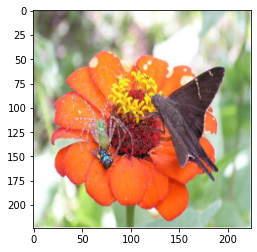

In [5]:
img = imread(img_path, size=(224, 224), channel_first=True)
plt.imshow(img.transpose(1,2,0))
plt.show()

## Network Definition
Loading the model is very simple.<br>
You can choose other models such as `VGG11`, `VGG13`, by specifying the model's name as an argument. Of course, you can choose other pretrained models as well. See the [Docs](https://nnabla.readthedocs.io/en/latest/python/api/models/imagenet.html).

**NOTE**: If you use the `VGG16` for the first time, nnabla will automatically download the weights from `https://nnabla.org` and it may take up to a few minutes.

In [6]:
model = VGG16()

2021-06-30 13:52:15,243 [nnabla][INFO]: Downloading VGG-16.nnp from https://nnabla.org/pretrained-models/nnp_models/imagenet/VGG-16/VGG-16.nnp
2021-06-30 13:52:15,245 [nnabla][INFO]: > /Users/kotaro.hayashi/nnabla_data/nnp_models/imagenet/VGG-16.nnp already exists.
2021-06-30 13:52:15,246 [nnabla][INFO]: > If you have any issue when using this file, 
2021-06-30 13:52:15,247 [nnabla][INFO]: > manually remove the file and try download again.


Loading /Users/kotaro.hayashi/nnabla_data/nnp_models/imagenet/VGG-16.nnp.


In [7]:
batch_size = 1
x = nn.Variable((batch_size,) + model.input_shape)
# set training True since gradient of variable is necessary for SHAP
vgg = model(x, training=True, returns_net=True)
vgg_variables = vgg.variables

We now define the input, and extract the necessary outputs.  
pred: final output of the model

In [8]:
target_label_indices = {
    'butterfly': 326,# lycaenid, lycaenid butterfly
    'flower': 985,# daisy
    'spider': 74,# garden spider
}

input_name = list(vgg.inputs.keys())[0]
vgg_variables[input_name].d = img
pred = vgg_variables["VGG16/Affine_3"]
selected = pred[:, target_label_indices['butterfly']]

Let's see how the model predicted the image.  
We can see the model classified the image as we expect.  
Labels regarding butterfly comes high, while flower is also recognized although it is14th ranked probability.

In [9]:
selected.forward()

In [10]:
predicted_labels = np.argsort(-pred.d[0])
for i, predicted_label in enumerate(predicted_labels[:15]):
        print(f'Top {i+1}, Label index: {predicted_label},  Label name: {model.category_names[predicted_label]}')

Top 1, Label index: 326,  Label name: lycaenid, lycaenid butterfly
Top 2, Label index: 716,  Label name: picket fence, paling
Top 3, Label index: 318,  Label name: lacewing, lacewing fly
Top 4, Label index: 321,  Label name: admiral
Top 5, Label index: 325,  Label name: sulphur butterfly, sulfur butterfly
Top 6, Label index: 323,  Label name: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
Top 7, Label index: 322,  Label name: ringlet, ringlet butterfly
Top 8, Label index: 658,  Label name: mitten
Top 9, Label index: 953,  Label name: pineapple, ananas
Top 10, Label index: 94,  Label name: hummingbird
Top 11, Label index: 319,  Label name: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk
Top 12, Label index: 310,  Label name: ant, emmet, pismire
Top 13, Label index: 309,  Label name: bee
Top 14, Label index: 985,  Label name: daisy
Top 15, Label index: 904,  Label name: window screen


## SHAP Computation

Execute funtion to compute SHAP and save the image.
We will compute SHAP for prediction to butterfly and prediction to flower.

In [11]:
from utils import shap_computation
shap_computation(model=model, X=img,
      label=target_label_indices['butterfly'], output="img_butterfly.png",
      interim_layer_index=10, num_samples=100,
      dataset=images, batch_size=25)
      

In [12]:
shap_computation(model=model, X=img,
      label=target_label_indices['flower'], output="img_flower.png",
      interim_layer_index=10, num_samples=100,
      dataset=images, batch_size=25)
      

# Visualization

Finally, compare images in oneline to enable to see the differences clearly.

In [13]:
img_butterfly = imread("img_butterfly.png", size=(224, 224),channel_first=True)
img_butterfly = img_butterfly.transpose(1,2,0)

img_flower = imread("img_flower.png", size=(224, 224), channel_first=True)
img_flower = img_flower.transpose(1,2,0)

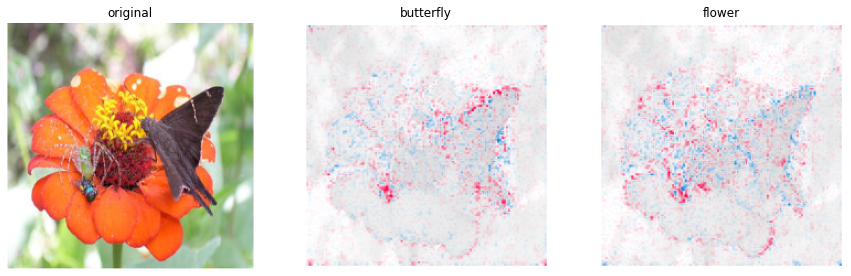

In [14]:
images = {
    'original': img.transpose(1,2,0),
    'butterfly': img_butterfly,
    'flower': img_flower,
}


row = 1
col = len(images)
fig, axes = plt.subplots(row, col, figsize=(15,15))

for i, (k, v) in enumerate(images.items()):
    axes[i].axis("off")
    axes[i].imshow(v)
    axes[i].set_title(k)

**Image on the middle (pridiction for butterfly)**: The edge of the butterfly appears red, and the edge of the flower appears blue. 

**Image on the right (pridiction for flower)**: The edge of the butterfly appears blue, and the edge of the flower appears red. 

The **red** pixels represents places where it affects **positive** influence to the prediction.<br>
On the other hand, **blue** pixels represents places where it affects **negative** influence to the prediction.<br>